In [1]:
molembed_path = "/home/wbm001/deeplpi/data/davis/mol.csv"
seqembed_path = "/home/wbm001/deeplpi/data/davis/seq_6165.csv"
train_path = "/home/wbm001/deeplpi/data/davis/trainset.csv"
test_path = "/home/wbm001/deeplpi/data/davis/testset.csv"
tensorboard_path = "/home/wbm001/deeplpi/DeepLPI/output/tensorboard/"
data_path = "/home/wbm001/deeplpi/DeepLPI/output/"

RAMDOMSEED = 11
CLASSIFYBOUND = -2

In [2]:
import pandas as pd

seqembed = pd.read_csv(seqembed_path)
molembed = pd.read_csv(molembed_path)
train = pd.read_csv(train_path)

(array([1.534e+04, 1.520e+03, 1.157e+03, 7.100e+02, 4.640e+02, 2.810e+02,
        1.470e+02, 6.800e+01, 2.400e+01, 4.000e+00]),
 array([-4.        , -3.43802112, -2.87604225, -2.31406337, -1.7520845 ,
        -1.19010562, -0.62812675, -0.06614787,  0.49583101,  1.05780988,
         1.61978876]),
 <BarContainer object of 10 artists>)

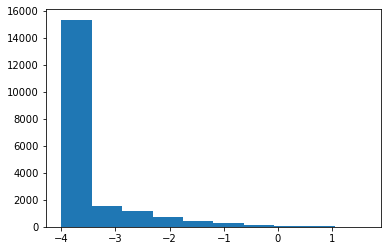

In [16]:
from matplotlib import pyplot as plt

plt.hist(train["pKd (nM)"])

In [8]:
seqembed = seqembed.set_index("id").iloc[:,1:]
molembed = molembed.set_index("id").iloc[:,1:]

In [9]:
import torch
from torch import tensor
from torch.utils.data import DataLoader,TensorDataset,SequentialSampler,RandomSampler
import numpy as np
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, test_size=1000, random_state=RAMDOMSEED)

# train
train_seq = tensor(np.array(seqembed.loc[train["seq"]])).to(torch.float32)
train_mol = tensor(np.array(molembed.loc[train["mol"]])).to(torch.float32)
train_classify = tensor(np.array(train["pKd (nM)"])).to(torch.float32)

trainDataset = TensorDataset(train_mol,train_seq,train_classify)
trainDataLoader = DataLoader(trainDataset, batch_size=64)

#val
val_seq = tensor(np.array(seqembed.loc[val["seq"]])).to(torch.float32)
val_mol = tensor(np.array(molembed.loc[val["mol"]])).to(torch.float32)
val_classify = tensor(np.array(val["pKd (nM)"])).to(torch.float32)

# valDataset = TensorDataset(val_mol,val_seq,val_classify)
# valDataLoader = DataLoader(valDataset, batch_size=256)

In [6]:
from torch.nn import Module
from torch import nn
import torch.nn.functional as F
import torch

In [10]:
class resBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_conv1=False, strides=1, dropout=0.3):
        super().__init__()
        
        self.process = nn.Sequential (
            nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=strides, padding=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels)
        )
        
        if use_conv1:
            self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=strides)
        else:
            self.conv1 = None
        
    def forward(self, x):
        left = self.process(x)
        right = x if self.conv1 is None else self.conv1(x)
        
        return F.relu(left + right)

In [11]:
class cnnModule(nn.Module):
    def __init__(self, in_channel, out_channel, hidden_channel=32, dropout=0.3, headpooling=False):
        super().__init__()

        self.head = nn.Sequential (
            nn.Conv1d(in_channel, hidden_channel, 7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(hidden_channel),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.MaxPool1d(5, stride=3) if headpooling == True else nn.MaxPool1d(2)
        )
        
        self.cnn = nn.Sequential (
            resBlock(hidden_channel, out_channel, use_conv1=True, strides=1),
            resBlock(out_channel, out_channel, strides=1),
            resBlock(out_channel, out_channel, strides=1),
        )
    
    def forward(self, x):
        x = self.head(x)
        x = self.cnn(x)
        
        return x

In [12]:
class DeepLPI(nn.Module):
    def __init__(self, molshape, seqshape, dropout=0.3):
        super().__init__()
        
        self.molshape = molshape
        self.seqshape = seqshape

        self.molcnn = cnnModule(1, 16, dropout=dropout)
        self.seqcnn = cnnModule(1, 16, dropout=dropout, headpooling=True)
        
        self.pool = nn.AvgPool1d(7, stride = 5, padding=2)
        self.lstm = nn.LSTM(16, 16, num_layers=2, batch_first=True, bidirectional=True)
        
        self.mlp = nn.Sequential (
            nn.Linear(round(self.molshape/4+self.seqshape/30) * 16 * 2, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            
            nn.Linear(1024, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            
            nn.Linear(128, 1),
        )

    def forward(self, mol, seq):
        mol = self.molcnn(mol.reshape(-1,1,self.molshape))
        seq = self.seqcnn(seq.reshape(-1,1,self.seqshape))
        
        # put data into lstm
        seq = self.pool(seq)
        # print(mol.shape,seq.shape)
        x = torch.cat((mol,seq),2)
        # print(mol.shape)
        x = x.reshape(-1,round(self.molshape/4+self.seqshape/30),16)

        x,_ = self.lstm(x)
        # fully connect layer
        # print(x.shape)
        x = self.mlp(x.flatten(1))
        
        x = x.flatten()
        
        return x

In [9]:
model = DeepLPI(300,6165)
model(torch.randn(512,300),torch.randn(512,6165)).shape

torch.Size([512])

In [13]:
def initialize_weights(m):
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)

    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)
        nn.init.constant_(m.bias.data, 0)

In [15]:
from matplotlib import pyplot as plt
import io

In [16]:
def train_loop(model, train_dataloader, lossfunc, optimizer, scheduler):
    model = model.to("cuda")
    model.train()
    loop_loss = 0
    
    for step, batch in enumerate(train_dataloader):
        step_mol, step_seq, step_label = batch
        step_mol, step_seq, step_label = step_mol.to("cuda"), step_seq.to("cuda"), step_label.to("cuda")

        optimizer.zero_grad()
        logits = model(step_mol, step_seq)
        loss = lossfunc(logits, step_label)
        loss.backward()
        optimizer.step()
        loop_loss += float(loss.to("cpu"))

        if step%20 == 0:
            print("step " + str(step) + " loss: " + str(float(loss.to("cpu"))))
        
    with torch.no_grad():
        return loop_loss/len(train_dataloader)

In [17]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score


def test_loop(model, val_mol, val_seq, val_lab, writer, epoch):
    model.eval()
    model = model.to("cuda")
    with torch.no_grad():
        step_mol, step_seq = val_mol.to("cuda"), val_seq.to("cuda")
        logits = model(step_mol,step_seq)
    logits = logits.to("cpu")

    fig = plt.figure(figsize=(6, 6))
    plt.xlabel("true value")
    plt.ylabel("predict value")
    plt.scatter(logits, val_lab, alpha = 0.2, color='Black')
    plt.plot(range(-9,4), range(-9,4),color="r",linewidth=2)
    plt.xlim(-9,4)
    plt.ylim(-9,4)
    writer.add_figure(tag='test evaluate', figure=fig, global_step=epoch)

    return mean_squared_error(val_lab,logits), r2_score(val_lab,logits)

In [1]:
import torch.optim as optim

model = DeepLPI(300,6165,dropout=0.2)

model.apply(initialize_weights)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, min_lr=0.00001)

from torch.utils.tensorboard import SummaryWriter
import time

writer = SummaryWriter(tensorboard_path)

for epoch in range(1000):
    print("--"*20)
    print("epoch: " + str(epoch))
    time0 = time.time()

    avgloss = train_loop(model, trainDataLoader, loss_fn, optimizer, scheduler)
    msescore, r2score = test_loop(model, val_mol, val_seq, val_classify, writer, epoch)

    writer.add_scalar("test time", time.time()-time0, epoch)
    writer.add_scalar('avgloss', avgloss , epoch)
    writer.add_scalar('mse', msescore , epoch)
    writer.add_scalar('r2', r2score , epoch)
    writer.add_scalar('current lr', optimizer.param_groups[0]['lr'], epoch)

    print()
    print("R2: " + str(r2score) + "\t MSE: " + str(msescore))
    print("use time: " + str(time.time() - time0))
    
    model.eval()
    if epoch % 50 == 0:
        torch.save({'state_dict': model.state_dict()}, data_path + 'model/' + str(version) + "e" + str(epoch) + '.pth.tar')
    else:
        torch.save({'state_dict': model.state_dict()}, data_path + "model/quicksave.pth.tar")


NameError: name 'DeepLPI' is not defined

In [19]:
import torch.optim as optim

model = DeepLPI(300,6165,dropout=0.2)

model.apply(initialize_weights)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, min_lr=0.00001)

from torch.utils.tensorboard import SummaryWriter
import time

writer = SummaryWriter(tensorboard_path)

for epoch in range(1000):
    print("--"*20)
    print("epoch: " + str(epoch))
    time0 = time.time()

    avgloss = train_loop(model, trainDataLoader, loss_fn, optimizer, scheduler)
    msescore, r2score = test_loop(model, val_mol, val_seq, val_classify, writer, epoch)

    writer.add_scalar("test time", time.time()-time0, epoch)
    writer.add_scalar('avgloss', avgloss , epoch)
    writer.add_scalar('mse', msescore , epoch)
    writer.add_scalar('r2', r2score , epoch)
    writer.add_scalar('current lr', optimizer.param_groups[0]['lr'], epoch)

    print()
    print("R2: " + str(r2score) + "\t MSE: " + str(msescore))
    print("use time: " + str(time.time() - time0))
    
    model.eval()
    if epoch % 50 == 0:
        torch.save({'state_dict': model.state_dict()}, data_path + 'model/' + str(version) + "e" + str(epoch) + '.pth.tar')
    else:
        torch.save({'state_dict': model.state_dict()}, data_path + "model/quicksave.pth.tar")

----------------------------------------
epoch: 0
step 0 loss: 20.074729919433594
step 20 loss: 6.435692310333252
step 40 loss: 3.4199204444885254
step 60 loss: 2.150752067565918

R2: -0.44635666295064036	 MSE: 0.88837296
use time: 14.252944707870483
----------------------------------------
epoch: 1
step 0 loss: 1.9945251941680908
step 20 loss: 1.095957636833191
step 40 loss: 1.2252490520477295
step 60 loss: 0.9822773337364197

R2: -0.19159300841212246	 MSE: 0.7318935
use time: 11.240354776382446
----------------------------------------
epoch: 2
step 0 loss: 0.9789406657218933
step 20 loss: 0.9517605304718018
step 40 loss: 0.8519464135169983
step 60 loss: 0.8187798261642456

R2: -0.05488035280685599	 MSE: 0.64792264
use time: 11.275174856185913
----------------------------------------
epoch: 3
step 0 loss: 0.7700061798095703
step 20 loss: 0.9832063913345337


KeyboardInterrupt: 

: 